In [143]:
import ciao_contrib.runtool as rt
import sherpa.astro.ui as ui
import numpy as np
import matplotlib.pyplot as plt
import os
import re

#astropy is used to read WCS position information from fits files for region_count
from astropy.io import fits
from astropy import wcs
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance

#spreadsheet is used to store the list of obsids by epoch and read the obs header information for lightcurve_counts
import spreadsheet

# import scalarformatter to change the number format of x axis tick labels
from matplotlib.ticker import ScalarFormatter

#%matplotlib widget
%matplotlib inline


def region_count(epoch_in):
    '''
    write _summary.txt files with the count rate and upper and lower bounds on the 90% confidence interval
    '''
    srcflx = rt.srcflux
    srcflx.punlearn() #Restore the system defaults for a CIAO parameter file.
    srcflx.infile = f'data/merge_test/epoch_{epoch_in}/merged_evt.fits'
    #with fits.open(srcflx.infile) as f:
        #loc = SkyCoord(f[1].header['RA_NOM']*u.deg,f[1].header['DEC_NOM']*u.deg)
        #loc_str = loc.ra.to_string(unit=u.hourangle, sep=':', pad=True, precision=2) + " " + loc.dec.to_string(unit=u.degree, sep=':', pad=True, precision=2)
    #srcflx.pos = loc_str #Reads RA, DEC columns as a position in sexagesimal "degree:arcmin:arcsec" format
    srcflx.pos = '13:09:48.0597,-23:22:52.836'
    srcflx.outroot = f'data/merge_test/epoch_{epoch_in}/srcflux_products/'
    srcflx.srcreg = f'regions/srcwcs.reg' #region used to calculate the source counts
    srcflx.bkgreg = f'regions/bkgwcs.reg'#region used to calculate the background counts
    srcflx.clobber = 'yes'
    srcflx.verbose = 0 #Default =1, 0 suppresses the long print statement
    srcflx() ## produces "_summary.txt" file with the output data parsed by read_counts

def merged_region_count(obsid_row,epoch_in):
    '''
    write _summary.txt files for merged observations
    '''
    srcflx = rt.srcflux
    srcflx.punlearn() #Restore the system defaults for a CIAO parameter file.
    srcflx.infile = str()
    for obsid in obsid_row:
        if srcflx.infile is None:
            srcflx.infile = f'data/{obsid}/repro/acisf{obsid}_repro_evt2.fits'
        else:
            srcflx.infile += f',data/{obsid}/repro/acisf{obsid}_repro_evt2.fits' ## includes leading comma
    print(srcflx.infile)
    srcflx.pos = '13:09:48.0597,-23:22:52.836'
    srcflx.outroot = f'data/epoch_{epoch_in}_srcflux_products/'
    srcflx.srcreg = f'regions/srcwcs.reg' #region used to calculate the source counts
    srcflx.bkgreg = f'regions/bkgwcs.reg'#region used to calculate the background counts
    srcflx.clobber = 'yes'
    srcflx.verbose = 0 #Default =1, 0 suppresses the long print statement
    srcflx() ## produces "_summary.txt" file with the output data parsed by read_counts
    
            
def read_counts(epoch, confidence_interval):
    #filename = f'data/merge_test/epoch_{epoch}/srcflux_products/_summary.txt'
    filename = f'flux_products_{confidence_interval}/epoch_{epoch}_flux_summary.txt'
    with open(filename, encoding='utf-8') as f:
        for line in f:
            count_rate_match = re.findall(r'([\d\.E\-]*)\s(c/s)',line)
            lb_match = re.findall(r'\([\d\.E\-]*\,', line)
            ub_match = re.findall(r'\,[\d\.E\-]*\)', line)
            #0001|13 9 48.47 -23 22 58.4  Rate           0.0014 c/s (0.00104,0.00183)      
            if count_rate_match:
                #print('\n'+count_rate_match.group(0))
                print(count_rate_match)
                cr = float(count_rate_match[1][0])
                print(lb_match)
                lb = float(lb_match[1][1:-1])
                ub = float(ub_match[1][1:-1])
                return(cr, lb, ub)

def read_obsids_csv(filename):
    '''
    read in the obsids.csv file and return the start times, end times, halfway times, and exposure times
    '''
    import pandas as pd
    obsids = pd.read_csv(filename)
    start_times = obsids['Observation Start *(days since GW170817)']
    end_times = obsids['Obs End *']
    halfway_times = obsids['Halfway Date T-T0 *']
    exposure_times = obsids['Exposure Time (ksec)']
    return(start_times, end_times, halfway_times, exposure_times)


def merge_obsids_into_epoch(obsid_in_list):
    '''
    params
    ------
    obsid_in_list : list
        List of observation IDs to be merged

    returns
    -------
    None
    '''
    ## previously used flxobs()
    mrgobs = rt.merge_obs
    epoch=4
    for obsid_row in obsid_in_list:
        mrgobs.punlearn()
        mrgobs.infiles = str()
        for obsid in obsid_row:
            if mrgobs.infiles is None:
                mrgobs.infiles = f'data/{obsid}/repro/acisf{obsid}_repro_evt2.fits'
            else:
                mrgobs.infiles += f', data/{obsid}/repro/acisf{obsid}_repro_evt2.fits' ## includes leading comma
        print('\nEpoch: '+str(epoch))
        print(mrgobs.infiles)

        mrgobs.outroot = f'data/merge_test/epoch_{epoch}/'
        mrgobs.clobber='yes'
        mrgobs()
        epoch +=1

def get_powerlaw_points(scaling_factor, exponent):
    '''
    Get a list of points (x,y) that define a powerlaw curve
    '''
    # Generate a list of points using a powerlaw curve
    # y = 7.126E-10 * x**(-1.9334)
    # use x values from 160 to 3000
    x = np.arange(200, 3000, 1)
    y = scaling_factor * x**(exponent)
    return(x,y)



def lightcurve_counts(epoch_in_list):
    '''
    produce a light curve of count rate vs time
    '''
    counts_list = []
    t_list = epoch_in_list
    yerr_list = []
    xerr_list = []
    lb_list = []
    ub_list = []
    for epoch in epoch_in_list:
        # Count is the number of counts during that epoch
        # lb and ub are the lower and upper bounds of the confidence interval
        [count, lb, ub] = read_counts(epoch)
        counts_list.append(count)

        lb_list.append(lb)
        ub_list.append(ub)
        

        #[t_t0,exp_time]=spreadsheet.epoch_header_parse(epoch)
        #t_list.append(t_t0)
        #xerr_list.append(exp_time/(3600*24)) ## convert observation times to days
    lb_list = np.array(lb_list)
    ub_list = np.array(ub_list)
    yerr_list = np.array([counts_list-lb_list, ub_list-counts_list])
    
    fig = plt.figure()
    plt.errorbar(t_list, counts_list, fmt='bo', yerr=yerr_list)    
    #log scale on y axis
    plt.yscale('log')
    return()

def lightcurve_flux(epoch_in_list):
    '''
    produce a light curve of flux vs time
    '''
    # Read data from obsids.csv
    [start_times, end_times, halfway_times, exposure_times] = read_obsids_csv('obsids.csv')

    t_list = np.array(halfway_times)
    t_err_up = np.array(end_times - halfway_times)
    t_err_lo = np.array(halfway_times - start_times)
    xerr_list = [t_err_lo, t_err_up]
    print(xerr_list)

    flux_list = []
    yerr_list = []
    lb_list = []
    ub_list = []
    conf_int = '68'
    for epoch in epoch_in_list:
        [flux, lb, ub] = read_flux(epoch, conf_int)
        flux_list.append(flux)
        lb_list.append(lb)
        ub_list.append(ub)

    lb_list = np.array(lb_list)
    ub_list = np.array(ub_list)
    yerr_list = np.array([flux_list-lb_list, ub_list-flux_list])

    # Make separate yerr_list, xerr_list, t_list, flux_list for the last epoch
    # so we can plot it in a different color
    t_list_last = t_list[-1]
    flux_list_last = flux_list[-1]
    yerr_list_last = [[yerr_list[0][-1]], [yerr_list[1][-1]]]
    xerr_list_last = [[xerr_list[0][-1]], [xerr_list[1][-1]]]

    # Make separate yerr_list, xerr_list, t_list, flux_list for the epoch 7
    # so we can plot it in a different color
    t_list_7 = t_list[7]
    flux_list_7 = flux_list[7]
    yerr_list_7 = [[yerr_list[0][7]], [yerr_list[1][7]]]
    xerr_list_7 = [[xerr_list[0][7]], [xerr_list[1][7]]]

    # Remove the last epoch from the error lists
    print(yerr_list)
    yerr_list = np.delete(yerr_list, -1, 1)
    print(yerr_list)
    xerr_list = np.delete(xerr_list, -1, 1)

    print(xerr_list_last)

    # Generate a list of points using a powerlaw curve
    x1,y1 = get_powerlaw_points(7.126E-10, -1.9334)
    x2,y2 = get_powerlaw_points(1.2134E-9, -2.0313)
    
    fig = plt.figure()
    plt.plot(x1,y1)
    # make dashed line for x2,y2
    plt.plot(x2,y2, linestyle='dashed')
    # make black dots for the flux points
    plt.errorbar(t_list[:-1], flux_list[:-1], fmt='k.', yerr=yerr_list, xerr=xerr_list)
    plt.errorbar(t_list_last, flux_list_last, fmt='g*', yerr=yerr_list_last, xerr=xerr_list_last)
    plt.errorbar(t_list_7, flux_list_7, fmt='r.', yerr=yerr_list_7, xerr=xerr_list_7)
    
    
    # print('for excel')
    # for i in range(len(flux_list)):
    #     print(flux_list[i],ub_list[i],lb_list[i],sep=' ')

    # Add plot legend
    plt.legend(['Powerlaw Full Fit', 'Powerlaw, removed Epoch 11', 'Observed Flux'])
    
    # Set y axis limits
    plt.ylim(3e-17, 8e-14)

    # Set x axis limits
    plt.xlim(60, 5000)

    #log scale on x,y axes
    plt.yscale('log')
    plt.xscale('log')

    # Change number format of x axis tick labels
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter())
    #ax.xaxis.set_minor_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='x', style='plain', useOffset=False)

    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$) for 0.3-10 keV')
    plt.xlabel('Days since GW170817')
    plt.title(f'Flux vs T-$T_0$ for the {conf_int}% Confidence Interval')

    # Set output file dpi
    plt.savefig('flux_vs_time.png', dpi=1200)


def read_flux(epoch, confidence_interval):
    #filename = f'data/merge_test/epoch_{epoch}/srcflux_products/_summary.txt'
    filename = f'flux_products_{confidence_interval}/epoch_{epoch}_flux_summary.txt'
    with open(filename, encoding='utf-8') as f:
        for line in f:
            count_rate_match = re.search(r'(Unabs).*?([\d\.E\-]*)\s(erg/cm2/s)',line)
            lb_match = re.search(r'\([\d\.E\-]*\,', line)
            ub_match = re.search(r'\,[\d\.E\-]*\)', line)
            #0001|13 9 48.47 -23 22 58.4  Rate           0.0014 c/s (0.00104,0.00183)      
            if count_rate_match:
                #print('\n'+count_rate_match.group(0))
                #print(count_rate_match.group(2))
                cr = float(count_rate_match.group(2).lower())
                lb = float(lb_match.group(0)[1:-1].lower())
                ub = float(ub_match.group(0)[1:-1].lower())
                return(cr, lb, ub)

In [118]:
def data_up_lo_to_latex_csv(data, up_err, lo_err, filename):
    ''' This function should take data and errors and write them to a csv file 
    in a format that can be read by latex. The format should be datapoint$^{+up_err}_{-lo_err}$
    '''
    with open(filename, 'w') as f:
        for i in range(len(data)):
            f.write(f'{data[i]}$^{{+{up_err[i]}}}_{{-{lo_err[i]}}}$ \n')

def print_up_lo_err(data, up_err, lo_err):
    for i in range(len(data)):
        print(f'{data[i]:.3f}$^{{+{up_err[i]:.3f}}}_{{-{lo_err[i]:.3f}}}$')

def data_to_latex_csv(data, err, filename):
    '''
    This function should take data and errors and write them to a csv file
    in a format that can be read by latex. The format should be datapoint$\pm$err
    '''
    with open(filename, 'w') as f:
        for i in range(len(data)):
            f.write(f'{data[i]}$\pm${err[i]} \n')

def print_err(data, err):
    for i in range(len(data)):
        # Print data to 3 decimal places, error to 2 decimal places
        print(f'{data[i]:.3f}$\pm${err[i]:.2f}')

        print(f'{data[i]}$\pm${err[i]}')


In [119]:
flux_list = []
lb_list = []
ub_list = []

for epoch in range(12):
    [flux, lb, ub] = read_flux(epoch, '68')
    flux_list.append(flux)
    lb_list.append(lb)
    ub_list.append(ub)

flux_list = np.array(flux_list)*1e15
lb_list = np.array(lb_list)*1e15
ub_list = np.array(ub_list)*1e15

# Round all lists to 3 decimal places
flux_list = np.round(flux_list, 3)
lb_list = np.round(lb_list, 3)
ub_list = np.round(ub_list, 3)

print_up_lo_err(flux_list, ub_list-flux_list, flux_list-lb_list)

23.200$^{+2.000}_{-1.900}$
24.000$^{+1.900}_{-2.000}$
12.900$^{+1.600}_{-1.500}$
7.750$^{+1.560}_{-1.380}$
2.800$^{+0.860}_{-0.740}$
2.020$^{+0.780}_{-0.650}$
1.360$^{+0.720}_{-0.586}$
2.480$^{+0.950}_{-0.800}$
0.845$^{+0.625}_{-0.509}$
0.427$^{+0.485}_{-0.374}$
0.228$^{+0.477}_{-0.228}$
0.203$^{+0.322}_{-0.203}$


In [144]:
# print counts table
counts_list = []
lb_list = []
ub_list = []

for epoch in range(12):
    [count, lb, ub] = read_counts(epoch, '68')
    counts_list.append(count)
    lb_list.append(lb)
    ub_list.append(ub)

counts_list = np.array(counts_list)*10e4
print(counts_list)
lb_list = np.array(lb_list)*10e4
ub_list = np.array(ub_list)*10e4

print_up_lo_err(counts_list, ub_list-counts_list, counts_list-lb_list)


[('0.00143', 'c/s'), ('0.00141', 'c/s')]
['(0.00131,', '(0.00129,']
[('0.00146', 'c/s'), ('0.00146', 'c/s')]
['(0.00135,', '(0.00134,']
[('0.000779', 'c/s'), ('0.000771', 'c/s')]
['(0.000688,', '(0.000682,']
[('0.000459', 'c/s'), ('0.000468', 'c/s')]
['(0.000377,', '(0.000387,']
[('0.00016', 'c/s'), ('0.000155', 'c/s')]
['(0.000117,', '(0.000117,']
[('0.000112', 'c/s'), ('0.000106', 'c/s')]
['(7.59E-05,', '(7.36E-05,']
[('7.27E-05', 'c/s'), ('8.18E-05', 'c/s')]
['(4.14E-05,', '(5.21E-05,']
[('0.000127', 'c/s'), ('0.000121', 'c/s')]
['(8.6E-05,', '(8.51E-05,']
[('4.29E-05', 'c/s'), ('5.32E-05', 'c/s')]
['(1.7E-05,', '(2.92E-05,']
[('2.08E-05', 'c/s'), ('2.35E-05', 'c/s')]
['(2.57E-06,', '(6.44E-06,']
[('1.09E-05', 'c/s'), ('6.5E-06', 'c/s')]
['(0,', '(0,']
[('9.39E-06', 'c/s'), ('1.89E-05', 'c/s')]
['(0,', '(7.21E-06,']
[141.   146.    77.1   46.8   15.5   10.6    8.18  12.1    5.32   2.35
   0.65   1.89]
141.000$^{+12.000}_{-12.000}$
146.000$^{+12.000}_{-12.000}$
77.100$^{+9.000}_{-8.9

In [ ]:
print_up_lo_err(start_times, start_times-halfway_times, end_times-halfway_times)

In [35]:
data_up_lo_to_latex_csv([1,2,3],[0.1,0.2,0.3],[0.1,0.2,0.3],'test.csv')
data_to_latex_csv([1,2,3],[0.13,0.2,0.3],'test.csv')

()

In [39]:
print_up_lo_err([1,2,3],[0.1,0.2,0.3],[0.1,0.2,0.3])

1$^{+0.1}_{-0.1}$
2$^{+0.2}_{-0.2}$
3$^{+0.3}_{-0.3}$


[array([ 1.8449823,  5.2354162,  1.0880067,  0.4066664,  1.49217  ,
        1.6093687,  3.2244556,  2.30585  ,  4.493578 ,  2.575533 ,
       32.13046  , 31.965992 ]), array([ 1.8449824,  5.2354161,  1.0880068,  0.4066664,  1.4921699,
        1.6093688,  3.2244557,  2.30585  ,  4.493578 ,  2.575532 ,
       32.13046  , 31.965993 ])]
for excel
2.32e-14 2.52e-14 2.13e-14
2.4e-14 2.59e-14 2.2e-14
1.29e-14 1.45e-14 1.14e-14
7.75e-15 9.31e-15 6.37e-15
2.8e-15 3.66e-15 2.06e-15
2.02e-15 2.8e-15 1.37e-15
1.36e-15 2.08e-15 7.74e-16
2.48e-15 3.43e-15 1.68e-15
8.45e-16 1.47e-15 3.36e-16
4.27e-16 9.12e-16 5.28e-17
2.28e-16 7.05e-16 0.0
2.03e-16 5.25e-16 0.0


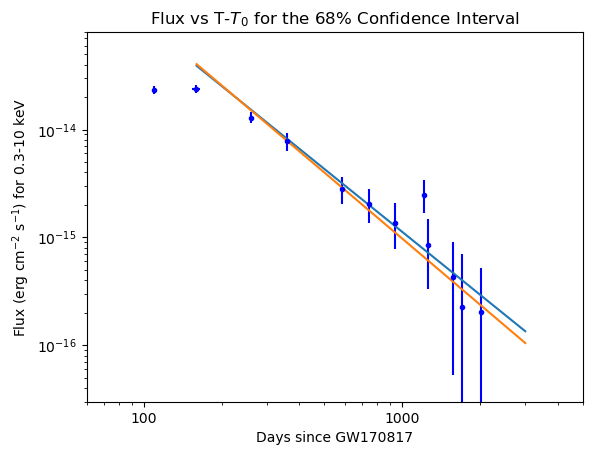

In [45]:
lightcurve_flux(range(12))

In [ ]:
#reproject(20936, 20860)
#obsid = 20861
#[count, lb, ub] = region_count(obsid)
#print(f'Obs ID {obsid} observed a count rate of {count} c/s')

from spreadsheet import epoch_obsid_list as eol
merge_obsids_into_epoch(eol)

#merge_observations([20860, 20936])

()

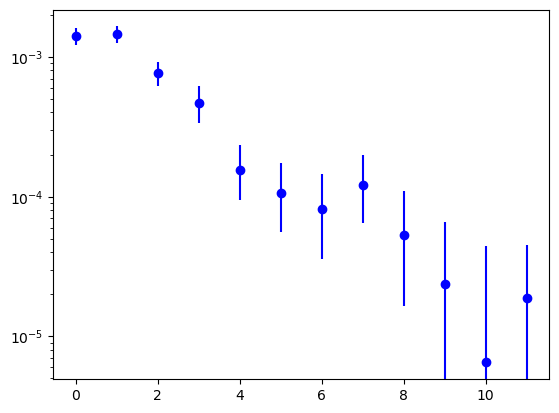

In [44]:
from spreadsheet import epoch_obsid_list as eol
lightcurve_counts(range(len(eol)))


[array([ 1.84498231,  5.23541618,  1.08800672,  0.4066664 ,  1.49216994,
        1.60936873,  3.22445564,  2.30584975,  4.49357833,  2.57553213,
       32.13045991, 31.96599229]), array([ 1.84498231,  5.23541618,  1.08800672,  0.4066664 ,  1.49216994,
        1.60936873,  3.22445564,  2.30584975,  4.49357833,  2.57553213,
       32.13045991, 31.96599229])]
[[1.900e-15 2.000e-15 1.500e-15 1.380e-15 7.400e-16 6.500e-16 5.860e-16
  8.000e-16 5.090e-16 3.742e-16 2.280e-16 2.030e-16]
 [2.000e-15 1.900e-15 1.600e-15 1.560e-15 8.600e-16 7.800e-16 7.200e-16
  9.500e-16 6.250e-16 4.850e-16 4.770e-16 3.220e-16]]
[[1.900e-15 2.000e-15 1.500e-15 1.380e-15 7.400e-16 6.500e-16 5.860e-16
  8.000e-16 5.090e-16 3.742e-16 2.280e-16]
 [2.000e-15 1.900e-15 1.600e-15 1.560e-15 8.600e-16 7.800e-16 7.200e-16
  9.500e-16 6.250e-16 4.850e-16 4.770e-16]]
[[31.96599229253502], [31.965992292534565]]


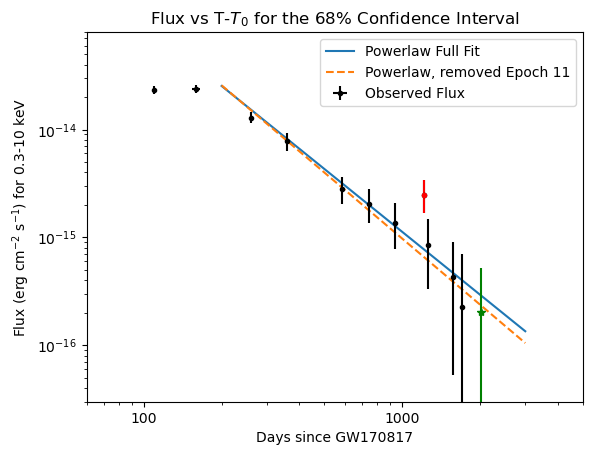

In [108]:
from spreadsheet import epoch_obsid_list as eol
lightcurve_flux(range(len(eol)))